# <center> <b style='font-size:1.5rem'> Projet “Construction d'un RAG avec le LLM Llama2 7B et LangChain” </b> </center>

# <b style='font-size:2rem'> Membres: Jules KOUABOUTI & Mary TRAORE </b>

**Objectif:** Dans ce notebook, nous allons créer un chatbot capable de répondre aux questions de plusieurs PDF, avec un LLM privé. Pour cela, nous utiliserons le dernier modèle GPTQ de Llama 2 7B pour discuter avec plusieurs PDF. Nous utiliserons la bibliothèque LangChain pour créer une chaîne capable de récupérer des documents pertinents et de répondre à leurs questions.

Nous allons également charger un modèle GPTQ à l'aide d'AutoGPTQ, à convertir un répertoire contenant des PDF en un vector store et à créer une chaîne à l'aide de LangChain qui fonctionne avec des textes chunks(morceaux de texte) du vector store.

In [ ]:
!nvidia-smi

Fri Feb 23 23:58:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8               8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## <b style='font-size:2rem'>Etape 1: Installation des packages nécessaires</b>

In [ ]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.0.1 --progress-bar off
!pip install -qqq transformers==4.31.0 --progress-bar off
!pip install -qqq langchain==0.0.266 --progress-bar off
!pip install -qqq chromadb==0.4.5 --progress-bar off
!pip install -qqq pypdf==3.15.0 --progress-bar off
!pip install -qqq xformers==0.0.20 --progress-bar off
!pip install -qqq sentence_transformers==2.2.2 --progress-bar off
!pip install -qqq InstructorEmbedding==1.0.1 --progress-bar off
!pip install -qqq pdf2image==1.16.3 --progress-bar off

  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xformers 0.0.20 requires torch==2.0.1, but you have torch 2.1.0 which is incompatible.


In [ ]:
!wget -q https://github.com/PanQiWei/AutoGPTQ/releases/download/v0.4.1/auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl

In [ ]:
!pip install -qqq auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl --progress-bar off

In [ ]:
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.3 [186 kB]
Fetched 186 kB in 0s (701 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 121749 

## <b style='font-size:2rem'> Étape 2 : Importer toutes les bibliothèques requises </b>

In [ ]:
import torch
from auto_gptq import AutoGPTQForCausalLM
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFDirectoryLoader, PyPDFLoader
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.schema.runnable import RunnablePassthrough
from langchain.chains import LLMChain
from pdf2image import convert_from_path
from transformers import (
    AutoTokenizer,
    TextStreamer,
    BitsAndBytesConfig,
    pipeline
)
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

## <b style='font-size:2rem'> Étape 3 : Charger les fichiers PDF </b>

In [ ]:
!mkdir pdfs

In [ ]:
!pip install gdown

In [ ]:
!gdown 1wPD196gT1jfxjHIiNjGMx_5iKrqZdZ8a -O pdfs/constitution-du-mali.pdf
!gdown 1pnSnvfGIATEeMXzlyEIInUqd50bLv83p -O pdfs/Rapport_Annuel_2022.pdf

Downloading...
From: https://drive.google.com/uc?id=1wPD196gT1jfxjHIiNjGMx_5iKrqZdZ8a
To: /content/pdfs/constitution-du-mali.pdf
100% 524k/524k [00:00<00:00, 119MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pnSnvfGIATEeMXzlyEIInUqd50bLv83p
To: /content/pdfs/Rapport_Annuel_2022.pdf
100% 24.9M/24.9M [00:00<00:00, 33.3MB/s]


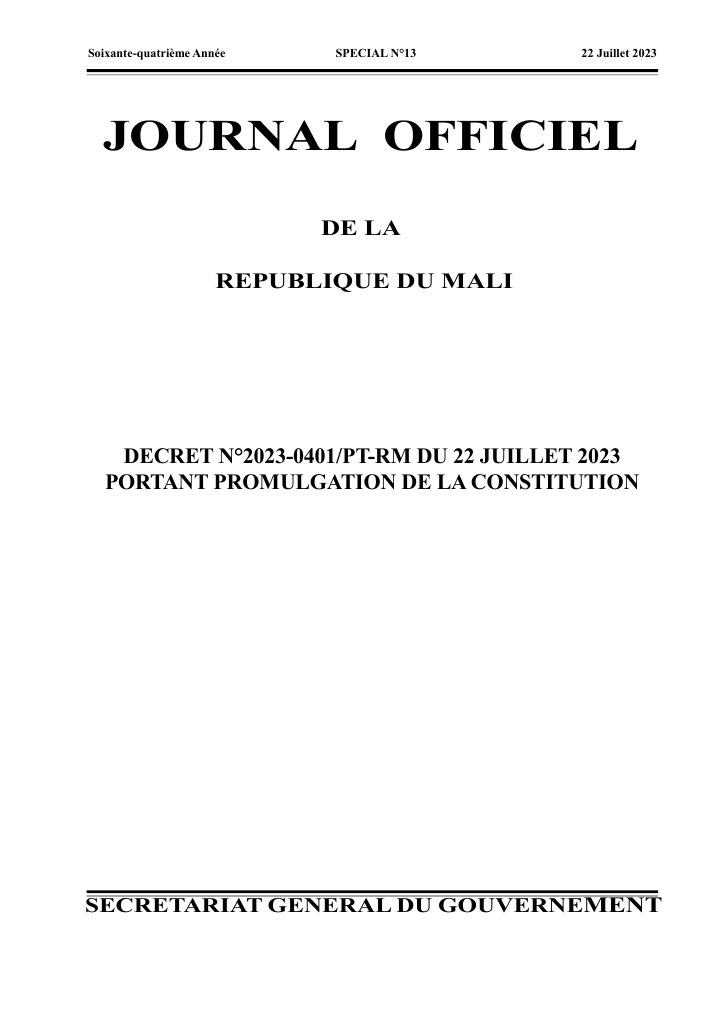

In [ ]:
constitution_images = convert_from_path("pdfs/constitution-du-mali.pdf", dpi=88)
constitution_images[0]

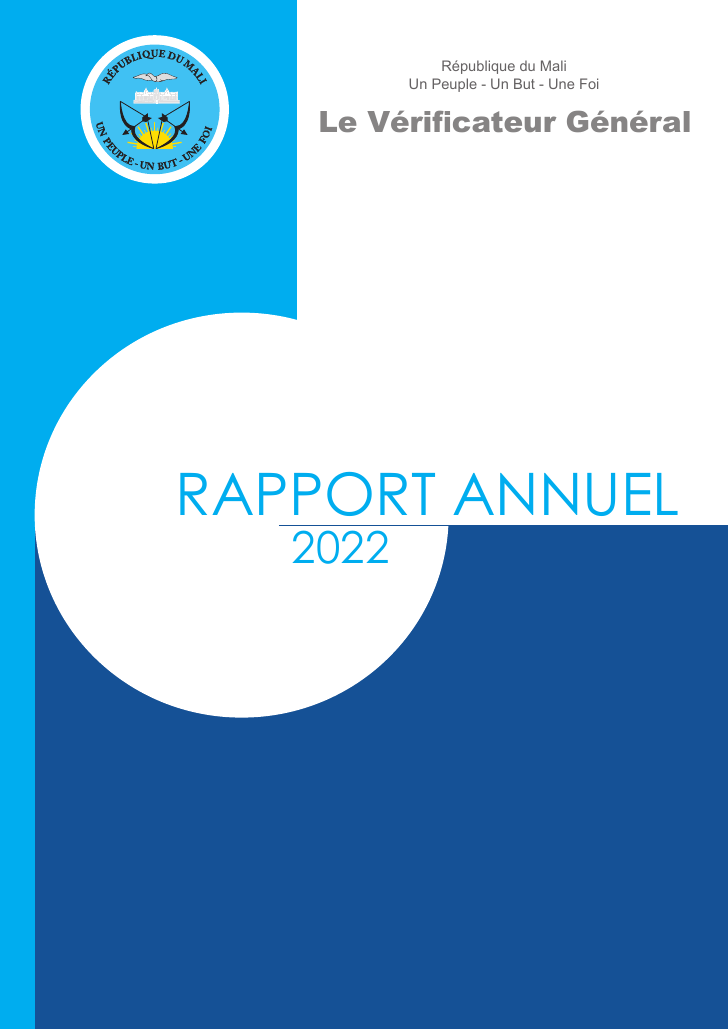

In [ ]:
rapport2022_images = convert_from_path("pdfs/Rapport_Annuel_2022.pdf", dpi=88)
rapport2022_images[0]

## <b style='font-size:2rem'> Étape 04 : Extraire le texte des PDF </b>

In [ ]:
!rm -rf "db"

In [ ]:
loader = PyPDFDirectoryLoader("pdfs")
docs = loader.load()
len(docs)

260

In [ ]:
docs

[Document(page_content='République du Mali\nUn Peuple - Un But - Une Foi\nRAPPORT ANNUEL\n2022Le Vérificateur Général', metadata={'source': 'pdfs/Rapport_Annuel_2022.pdf', 'page': 0}),
 Document(page_content='Le Vérifica teur Génér al\nRAPPORT ANNUEL 2022\n', metadata={'source': 'pdfs/Rapport_Annuel_2022.pdf', 'page': 1}),
 Document(page_content='', metadata={'source': 'pdfs/Rapport_Annuel_2022.pdf', 'page': 2}),
 Document(page_content='', metadata={'source': 'pdfs/Rapport_Annuel_2022.pdf', 'page': 3}),
 Document(page_content='2Aperçu de l’organisation\nFace à la volonté affichée de renforcer le contrôle de la gestion \npublique, les autorités maliennes ont institué le Vérificateur Général \nsuivant Loi n°03-030 du 25 août 2003. Cette loi a été abrogée \net remplacée par la Loi n°2012-009 du 8 février 2012 en vue de \nrenforcer son ancrage institutionnel et de le rendre plus efficace. \nPar la suite, dans un souci de corriger certaines insuffisances qui \nne permettaient pas au Vérific

## <b style='font-size:2rem'> Étape 05 : diviser les données extraites en morceaux de texte </b>

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts = text_splitter.split_documents(docs)
len(texts)

629

In [ ]:
print(texts[0].page_content)

République du Mali
Un Peuple - Un But - Une Foi
RAPPORT ANNUEL
2022Le Vérificateur Général


## <b style='font-size:2rem'> Étape 06 : Télécharger un model pour l'embedding </b>

In [ ]:
embeddings = HuggingFaceInstructEmbeddings(
    model_name="hkunlp/instructor-large", model_kwargs={"device": DEVICE}
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.41k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

load INSTRUCTOR_Transformer
max_seq_length  512


## <b style='font-size:2rem'> Étape 07 : Configuration de Chroma comme base de données vectorielles</b>

In [ ]:
%%time
db = Chroma.from_documents(texts, embeddings, persist_directory="db")

CPU times: user 36.2 s, sys: 649 ms, total: 36.9 s
Wall time: 42.1 s


## <b style='font-size:2rem'> Étape 08 : Chargement du model Llama 2 7B</b>

In [ ]:
model_name_or_path = "TheBloke/Llama-2-7B-Chat-GPTQ"
model_basename = "model"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

model = AutoGPTQForCausalLM.from_quantized(
    model_name_or_path,
    revision="gptq-4bit-128g-actorder_True",
    model_basename=model_basename,
    use_safetensors=True,
    trust_remote_code=True,
    inject_fused_attention=False,
    device=DEVICE,
    quantize_config=None,
)


tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/789 [00:00<?, ?B/s]

1. You disabled CUDA extensions compilation by setting BUILD_CUDA_EXT=0 when install auto_gptq from source.
2. You are using pytorch without CUDA support.
3. CUDA and nvcc are not installed in your device.


config.json:   0%|          | 0.00/766 [00:00<?, ?B/s]

quantize_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

## <b style='font-size:2rem'> Infos sur les paramètres du modèle</b>

In [ ]:
def print_number_of_trainable_model_parameters(model):
  trainable_model_params = 0
  all_model_params = 0
  for _, param in model.named_parameters():
    all_model_params += param.numel()
    if param.requires_grad:
      trainable_model_params += param.numel()
  return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npourcentage of trainable model parameters: {100 * (trainable_model_params / all_model_params)}"

print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 262410240
all model parameters: 1073270784
pourcentage of trainable model parameters: 24.44958382469116


## <b style='font-size:2rem'> Définition d'un template</b>

In [ ]:
DEFAULT_SYSTEM_PROMPT = """
You are a helpful, respectful and honest assistant. Always respond in the most helpful way possible, while being careful. Your responses must not include any harmful, unethical, racist, sexist, toxic, dangerous or illegal content. Please ensure your responses are socially unbiased and positive in nature.

If a question doesn't make sense or is factually inconsistent, explain why instead of answering something that isn't correct. If you do not know the answer to a question, please do not share false information.
""".strip()


def generate_prompt(prompt: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f"""
[INST] <<SYS>>
{system_prompt}
<</SYS>>

{prompt} [/INST]
""".strip()

In [ ]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

## <b style='font-size:2rem'> Création de la chaine</b>

In [ ]:
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024,
    temperature=0,
    top_p=0.95,
    repetition_penalty=1.15,
    streamer=streamer,
)

    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.1.0+cu121)
    Python  3.10.11 (you have 3.10.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
The model 'LlamaGPTQForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'Marian

#### Pipeline du model

In [ ]:
llm = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature": 0})

In [ ]:
SYSTEM_PROMPT = "Use the following context to answer the question at the end. If you don't know the answer, just say you don't know, don't try to make up an answer."

template = generate_prompt(
    """
{context}

Question: {question}
""",
    system_prompt=SYSTEM_PROMPT,
)

In [ ]:
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [ ]:
llm_chain = LLMChain(llm=llm, prompt=prompt)

##### 1. D’abord, en se basant sur la ou les sources de données externes utilisées dans le RAG, formulez 2 questions permettant de démontrer que sans RAG, le LLM seul ne sait pas répondre à ces questions.

#### Invocation du LLM sans RAG

In [ ]:
llm_chain.invoke({"context":"",
                  "question": "What was the General Auditor's report on the financial audit of the management of the Rural Commune of Tiémala-Banimonotié?"})

 I apologize, but I cannot provide information or answers based on a fictional context or scenario. The General Auditor's report on the financial audit of the management of the Rural Commune of Tiémala-Banimonotié does not exist in reality, and therefore I cannot provide any information about it. Please let me know if there is anything else I can help you with.


{'context': '',
 'question': "What was the General Auditor's report on the financial audit of the management of the Rural Commune of Tiémala-Banimonotié?",
 'text': "  I apologize, but I cannot provide information or answers based on a fictional context or scenario. The General Auditor's report on the financial audit of the management of the Rural Commune of Tiémala-Banimonotié does not exist in reality, and therefore I cannot provide any information about it. Please let me know if there is anything else I can help you with."}

In [ ]:
llm_chain.invoke({"context":"",
                  "question": "Who promulgated the constitution of MALI say on the basis of DECREE N°2023-0401/PT-RM OF JULY 22, 2023"})

 I apologize, but I cannot provide information on the constitution of Mali or any other country based on a specific decree number. The accuracy and reliability of such information depend on various factors, including the source of the information and its relevance to the current situation in Mali.
As a responsible AI language model, I must rely on credible sources of information and avoid providing answers that may be misleading or incorrect. Therefore, I do not have the answer to your question regarding who promulgated the constitution of Mali based on Decree No. 2023-0401/PT-RM of July 22, 2023. If you have any further questions or concerns, please feel free to ask.


{'context': '',
 'question': 'Who promulgated the constitution of MALI say on the basis of DECREE N°2023-0401/PT-RM OF JULY 22, 2023',
 'text': '  I apologize, but I cannot provide information on the constitution of Mali or any other country based on a specific decree number. The accuracy and reliability of such information depend on various factors, including the source of the information and its relevance to the current situation in Mali.\nAs a responsible AI language model, I must rely on credible sources of information and avoid providing answers that may be misleading or incorrect. Therefore, I do not have the answer to your question regarding who promulgated the constitution of Mali based on Decree No. 2023-0401/PT-RM of July 22, 2023. If you have any further questions or concerns, please feel free to ask.'}

##### 2. Toujours en ce basant sur les sources externes utilisées dans le RAG, posez les 2 questions formulées précedemment au LLM intégrant cette fois le RAG. Les résultats obtenues sont-ils conforment aux informations contenues dans les documents sources externes ?

### Invoker le LLM en ce basant sur le context(la base de donnée vectorielle chroma)

In [ ]:
rag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

In [ ]:
result = rag_chain("What was the General Auditor's report on the financial audit of the management of the Rural Commune of Tiémala-Banimonotié?")


 According to the provided context, the General Auditor's report on the financial audit of the management of the Rural Commune of Tiémala-Banimonotié revealed several irregularities, including:
* Irregularities in the payment of salaries, with some employees receiving more than their due salary.
* Unjustified advances and reimbursements made to certain officials.
* Failure to deduct and pay taxes on income from rentals of immovable property.
* Mismanagement of public funds, with some funds being used for personal purposes.
The report also noted that the Director Financial and Accounting had not taken into account the Income Tax and Land Tax on rental income received. After reviewing the preliminary report, the Public Ministry of Finance (PMU) conducted regularization procedures for the amount involved by issuing a check to the Order of the Treasury.


In [ ]:
result = rag_chain("Who promulgated the constitution of MALI say on the basis of DECREE N°2023-0401/PT-RM OF JULY 22, 2023")

 Based on DECREE N°2023-0401/PT-RM OF JULY 22, 2023, the President of the Transition, who is also the Chief of State, promulgated the Constitution of Mali. Therefore, the answer is "The President of the Transition."


In [ ]:
len(result["source_documents"])

2

In [ ]:
print(result["source_documents"][0].page_content)

Soixante-quatrième Année                                    SPECIAL N°13                                                      22 Juillet 2023
       JOURNAL  OFFICIEL
DE LA
 REPUBLIQUE DU MALI
SECRETARIAT GENERAL DU GOUVERNE MENTDECRET N°2023-0401/PT-RM DU 22 JUILLET 2023
PORTANT PROMULGATION DE LA CONSTITUTION


Sur la base de nos observations et remarques les résulats obténues par LLM intégrant le RAG sont en accord avec le contenu de nos documents importés.

##### 3. Formulez 3 questions supplémentaires partant des documents sources et posez les au LLM intégrant le RAG. Les résultats obténus sont-ils conforment aux informations contenues dans le documents sources externes ?texte en gras

**Question 1**

In [ ]:
result = rag_chain("what does article 1 of the MALI constitution say?")

 According to the provided context, Article 1 of the Mali Constitution reads:
"The Malian people, rich in their cultural, linguistic, and religious diversity; proud of their ancient history and ancestors; inheritor of great empires and kingdoms built on sociocultural values that inspire present and future generations; faithful to the ideals of the martyrs of colonialism, the fathers of independence, and all those who have fallen in the struggle for freedom; hereby proclaim this Constitution."


In [ ]:
print(result["source_documents"][1].page_content)

JOURNAL OFFICIEL DE LA REPUBLIQUE DU MALI   2
DECRET N°2023-0401/PT-RM DU 22 JUILLET 2023
PORTANT PROMULGATION DE LA CONSTITUTION
Vu la Charte de la Transition ;
Vu la Loi n°2022-001 du 25 février 2022 portant révision
de la Charte de la Transition ;
Vu l’Arrêt n°2023-08/CC-Réf du 21 juillet 2023 portant
proclamation des résultats définitifs du référendum
constitutionnel (scrutin du 18 juin 2023) ;
Considérant les conclusions des Assises nationales de la
Refondation de l’Etat du 30 décembre 2021,
Le Président de la Transition, Chef de l’Etat, promulgue la
Constitution dont la teneur suit :
PREAMBULE  :
Le Peuple souverain du Mali,
Riche de sa diversité culturelle, linguistique et religieuse ;
Fier de son histoire millénaire et de ses ancêtres ;
Héritier de grands empires et royaumes bâtis sur des valeurs
socioculturelles endogènes devant inspirer les générations
présentes et futures ;
Fidèle aux idéaux des martyrs du colonialisme, des pères
de l’indépendance et de tous ceux qui sont to

**Question 2**

In [ ]:
result = rag_chain("the financial audit of the management of the Rural Commune of Tiémala-Banimonotié recovered what amount from a village chief?")

 According to the text, the financial audit recovered 280,000 FCFA from a village chief as a contribution towards the financing of a borehole.


In [ ]:
print(result["source_documents"][1].page_content)

280 000 FCFA  auprès d’un Chef de village à titre de contribution pour la 
réalisation d’un forage intégralement financé sur Budget National/ANICT. 
La CRTB a fourni la preuve du remboursement effectif du montant après la 
transmission du rapport provisoire.
Vérification financière de la gestion de la Commune Rurale de 
Zantiébougou :
Il est ressorti de la vérification que le Secrétaire général n’avait pas reversé 
au Régisseur de recettes des redevances de mariage recouvrées pour un 
montant total de 65 000 FCFA . Après la transmission du rapport provisoire, 
ce montant a été reversé à la Régie de recettes suivant quittance n°3389235 
du 30 décembre 2022.
Vérification financière de la gestion de la Commune Urbaine de Mopti :
La vérification a révélé que le Maire de la CUM avait ordonné le paiement de 
travaux non conformes aux devis quantitatifs. Dans le cadre de l’exécution 
d’un marché relatif à la réhabilitation d’un groupe scolaire, le titulaire n’a


**Question 3**

In [ ]:
# result = rag_chain("summarize for me the conclusion of the Auditor General's document")

In [ ]:
result = rag_chain("Who is the President of the Transition, Head of State who promulgated the new constitution ?")

 Based on the provided context, the President of the Transition, Head of State who promulgated the new constitution is Colonel Assimi Goita.


##### 4. Quelles sont vos rémarques sur les LLM et le RAG sur la base de cette expérimentation ?

Après avoir expérimenté et mettre en œuvre le Reasoning and Analysis Graph (RAG), nous avons été profondément inspirés et avons pris conscience des opportunités qui peuvent découler de l'intégration du modèle de LLM dans un environnement privé. Ce travail a également renforcé notre conviction quant aux avantages tangibles que cette approche peut apporter en termes gain de temps et de prise de décision pour les entreprises.